# Import packages

In [1]:
# Run this if running in Google Collab
# Mount google drive if running from Google Collab
from google.colab import drive
drive.mount('/content/drive')

# Set current directory if running from Google Collab
import os
os.chdir('/content/drive/My Drive/Carbon_price_prediction/Workspace/Data')

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import pickle

Mounted at /content/drive


# Custom functions

In [18]:
def tf_idf(df: pd.DataFrame) -> pd.DataFrame:
    """
    Creates TF-IDF scores based on term-document matrix

    Parameters:
        df (pandas DataFrame):term-document dataframe

    Returns:
        tf_idf_df (pandas DataFrame): Dataframe of TF-IDF scores

    """

    # Count term occurences across documents (dates in ur case)
    nt = (df > 0).sum(axis=0)

    # Broadcast to dataframe for compatible shapes
    nt = (df < 0) + nt

    # Get number of documents
    N = len(df)

    # Implementation based on the 2. recommended option here: https://en.wikipedia.org/wiki/Tf%E2%80%93idf
    tf_idf_df = np.log(1 + df) * np.log(1 + N / nt)

    return tf_idf_df

In [ ]:
def agg_keyword_index_tf_idf_plot(ma_window, first_date, df):
    filtered_df = df[df.index > first_date]

    plt.plot(filtered_df, label='Raw scores', alpha=0.2)
    plt.plot(filtered_df.rolling(ma_window).mean(), label=f'{ma_window}-day moving average')
    plt.ylabel("TF-IDF score")
    plt.title("Time series of aggregated keyword index")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'./tf_idf/aggregated_tf_idf_index_ts_{ma_window}_first_date_{first_date.strftime("%Y%m%d")}.pdf')
    plt.show()

# Parameters / Constants

In [2]:
ngram = 1
ngrams = [1, 2, 3]

# Data import

In [3]:
dfs = [pd.read_csv(f'./merged_articles_carbon_keyword_term_document_matrix_ngram_{ngram}.csv', index_col=0)
       for ngram in ngrams]
df = pd.concat(dfs, axis=1)
print(df.shape)
print(df.head())

(18937, 36)
   ghg  climate  sustainability  sustainable  environment  coal  gas  oil  \
0    0        2               0            0            0     0    1    2   
1    0        0               0            0            0     0    0    0   
2    0        0               0            0            0     0    0    0   
3    0        0               0            0            0     0    0    0   
4    0        0               0            0            1     0    0    0   

   crude  gasoline  ...  gas heating  gas turbine  fossil fuel  nuclear power  \
0      0         0  ...            0            0            0              0   
1      0         0  ...            0            0            0              0   
2      0         0  ...            0            0            0              0   
3      0         0  ...            0            0            0              0   
4      0         0  ...            0            0            0              0   

   nuclear plant  nuclear energy  clea

In [4]:
id_date_map_df = pd.read_csv(f'./lemmatized_merged_articles.csv', index_col=0)
id_date_map_df.shape

(18937, 2)

In [5]:
df.shape

(18937, 36)

In [6]:
# Reindex keyword counts by dates
df = df.rename(index=id_date_map_df['date'].squeeze().to_dict())
print(df.head())

            ghg  climate  sustainability  sustainable  environment  coal  gas  \
2017-01-01    0        2               0            0            0     0    1   
2017-01-01    0        0               0            0            0     0    0   
2017-01-01    0        0               0            0            0     0    0   
2017-01-01    0        0               0            0            0     0    0   
2017-01-01    0        0               0            0            1     0    0   

            oil  crude  gasoline  ...  gas heating  gas turbine  fossil fuel  \
2017-01-01    2      0         0  ...            0            0            0   
2017-01-01    0      0         0  ...            0            0            0   
2017-01-01    0      0         0  ...            0            0            0   
2017-01-01    0      0         0  ...            0            0            0   
2017-01-01    0      0         0  ...            0            0            0   

            nuclear power  nucle

In [7]:
# Sanity check
print(min(df.index))
print(max(df.index))

2017-01-01
2021-12-12


# Data Preprocessing

In [8]:
# Aggregate by dates
agg_df = df.groupby(df.index).sum()

In [9]:
agg_df

,ghg,climate,sustainability,sustainable,environment,coal,gas,oil,crude,gasoline,...,gas heating,gas turbine,fossil fuel,nuclear power,nuclear plant,nuclear energy,clean energy,green energy,emission trading system,emission trading scheme
2017-01-01,0,2,0,0,1,0,2,3,0,0,...,0,0,0,0,0,0,0,0,0,0
2017-01-02,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2017-01-03,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2017-01-04,0,0,0,0,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2017-01-05,0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-08,0,0,0,4,1,0,5,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2021-12-09,0,2,0,0,1,0,2,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2021-12-10,0,17,0,3,1,1,5,6,0,1,...,0,0,1,1,0,3,0,0,0,0
2021-12-11,0,0,0,0,0,0,5,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# TF-IDF generation

In [14]:
# Generate TF-IDF scores
tf_idf_df = tf_idf(agg_df)

In [ ]:
tf_idf_df

,ghg,climate,sustainability,sustainable,environment,coal,gas,oil,crude,gasoline,...,gas heating,gas turbine,fossil fuel,nuclear power,nuclear plant,nuclear energy,clean energy,green energy,emission trading system,emission trading scheme
2017-01-01,0.0,1.267604,0.0,0.000000,0.854682,0.000000,1.373904,1.697494,0.0,0.000000,...,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0
2017-01-02,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0
2017-01-03,0.0,0.799769,0.0,0.000000,0.000000,0.000000,0.866837,0.000000,0.0,0.000000,...,0.0,0.0,0.000000,0.000000,0.0,2.588125,0.0,0.000000,0.0,0.0
2017-01-04,0.0,0.000000,0.0,0.000000,1.709364,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0
2017-01-05,0.0,0.000000,0.0,0.963518,0.000000,1.527475,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-08,0.0,0.000000,0.0,2.237219,0.854682,0.000000,2.240740,0.000000,0.0,0.000000,...,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,2.825955,0.0,0.0
2021-12-09,0.0,1.267604,0.0,0.000000,0.854682,0.000000,1.373904,0.848747,0.0,0.000000,...,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0
2021-12-10,0.0,3.334977,0.0,1.927036,0.854682,1.527475,2.240740,2.382734,0.0,2.572924,...,0.0,0.0,1.889075,1.830331,0.0,5.176249,0.0,0.000000,0.0,0.0
2021-12-11,0.0,0.000000,0.0,0.000000,0.000000,0.000000,2.240740,0.000000,0.0,0.000000,...,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0


# Export results

In [ ]:
tf_idf_df.to_csv(f'./tf_idf_gdelt_lemmatized_custom_keywords.csv')

# Aggregated keywords "index"

In [50]:
agg_keyword_index_df = df.groupby(df.index).sum().sum(axis=1)
agg_keyword_index_df

2017-01-01     9
2017-01-02     0
2017-01-03     7
2017-01-04     3
2017-01-05     2
              ..
2021-12-08    17
2021-12-09     8
2021-12-10    45
2021-12-11     8
2021-12-12    16
Length: 1797, dtype: int64

In [51]:
agg_keyword_index_tf_idf_df = tf_idf(agg_keyword_index_df)

In [52]:
agg_keyword_index_tf_idf_df

2017-01-01    1.756749
2017-01-02    0.000000
2017-01-03    1.586503
2017-01-04    1.057668
2017-01-05    0.838182
                ...   
2021-12-08    2.205199
2021-12-09    1.676365
2021-12-10    2.921049
2021-12-11    1.676365
2021-12-12    2.161590
Length: 1797, dtype: float64

In [53]:
# Converting the index to date type
agg_keyword_index_tf_idf_df.index = pd.to_datetime(agg_keyword_index_tf_idf_df.index)

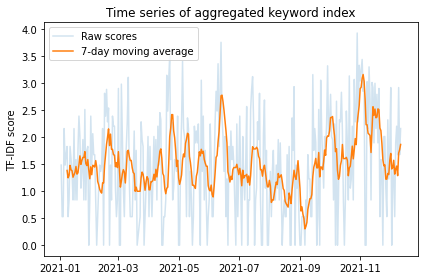

In [54]:
# Visualize index over time
ma_window = 7
first_date = pd.to_datetime('2021-01-01')

agg_keyword_index_tf_idf_plot(ma_window, first_date, agg_keyword_index_tf_idf_df)

# Support

In [ ]:
# Single dataframe
# df = pd.read_csv(f'./merged_articles_carbon_keyword_term_document_matrix_ngram_{ngram}.csv', index_col=0)
# df.head()

In [ ]:
# nt = (agg_df > 0).sum(axis=0)
# nt = (agg_df < 0) + nt
# print(nt)

            ghg  climate  sustainability  sustainable  environment  coal  gas  \
2017-01-01    3      828             128          596          739   223  721   
2017-01-02    3      828             128          596          739   223  721   
2017-01-03    3      828             128          596          739   223  721   
2017-01-04    3      828             128          596          739   223  721   
2017-01-05    3      828             128          596          739   223  721   
...         ...      ...             ...          ...          ...   ...  ...   
2021-12-08    3      828             128          596          739   223  721   
2021-12-09    3      828             128          596          739   223  721   
2021-12-10    3      828             128          596          739   223  721   
2021-12-11    3      828             128          596          739   223  721   
2021-12-12    3      828             128          596          739   223  721   

            oil  crude  gas

In [ ]:
# # Implementation based on the 2. recommended option here: https://en.wikipedia.org/wiki/Tf%E2%80%93idf
# N = len(agg_df)

# tf_idf_df = np.log(1 + agg_df) * np.log(1 + N / nt)

In [ ]:
# agg_keyword_index_tf_idf_df[agg_keyword_index_tf_idf_df.index > pd.to_datetime('2021-10-10')]

In [ ]:
# plt.plot(agg_keyword_index_tf_idf_df, label='Raw scores', alpha=0.7)
# plt.plot(agg_keyword_index_tf_idf_df.rolling(ma_window).mean(), label=f'{ma_window}-day moving average')
# plt.ylabel("TF-IDF score")
# plt.title("TEST")
# plt.tight_layout()
# plt.savefig(f'./tf_idf/aggregated_tf_idf_index_ts.pdf')
# plt.show()